# 1. Imports

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import model_selection
from google.cloud import bigquery

%matplotlib inline
plt.style.use('fivethirtyeight')

In [7]:
df = pd.read_gbq('SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_status` LIMIT 200',
                 project_id='mids205-205023',
                 dialect='standard')

In [9]:
df.head()

,station_id,bikes_available,docks_available,time
0,87,0,0,2016-07-18 08:40:01
1,87,0,0,2016-07-18 10:48:01
2,90,1,30,2016-08-30 17:04:01
3,90,2,29,2016-08-30 07:55:47
4,90,2,29,2016-08-30 10:54:01


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
station_id         200 non-null int64
bikes_available    200 non-null int64
docks_available    200 non-null int64
time               200 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.3 KB


# 2. Data Pull

## 2.1. Bike Share Trips

In [6]:
#! bq query --use_legacy_sql=false  --format=csv --max_rows=1000000 --maximum_bytes_billed=300000000 \
#'SELECT \
#    * \
#FROM \
#  `bigquery-public-data.san_francisco.bikeshare_trips`' > result.csv

#df = pd.read_csv('result.csv', parse_dates=['start_date', 'end_date'])

Waiting on bqjob_r7fadec1ad7a43b28_00000164114f89ba_1 ... (0s) Current status: DONE   

In [19]:
sql = """
SELECT
    *
FROM 
    `bigquery-public-data.san_francisco.bikeshare_trips`
"""
df = pd.read_gbq(query=sql,
                 project_id='mids205-205023',
                 dialect='standard')

In [22]:
df['start_date_dow'] = df.start_date.dt.weekday_name
df['start_date_day'] = df.start_date.dt.floor('d')
df['start_date_month'] = df.start_date.dt.to_period('M').dt.to_timestamp()
df['start_date_moy'] = df.start_date.apply(lambda x: x.strftime("%B"))
df['start_date_tod'] = df.start_date.dt.hour
df['start_date_hour'] = df.start_date.dt.floor('h')
df.start_date_dow = pd.Categorical(df.start_date_dow, ['Sunday',
                                                       'Monday',
                                                       'Tuesday',
                                                       'Wednesday',
                                                       'Thursday',
                                                       'Friday',
                                                       'Saturday'])

df['end_date_dow'] = df.end_date.dt.weekday_name
df['end_date_day'] = df.start_date.dt.floor('d')
df['end_date_month'] = df.end_date.dt.to_period('M').dt.to_timestamp()
df['end_date_moy'] = df.end_date.apply(lambda x: x.strftime("%B"))
df['end_date_tod'] = df.start_date.dt.hour
df['end_date_hour'] = df.end_date.dt.floor('h')
df.end_date_dow = pd.Categorical(df.end_date_dow, ['Sunday',
                                                   'Monday',
                                                   'Tuesday',
                                                   'Wednesday',
                                                   'Thursday',
                                                   'Friday',
                                                   'Saturday'])

## 2.2. Bike Share Status

In [ ]:
! bq query --use_legacy_sql=false  --format=csv --max_rows=6000000 --maximum_bytes_billed=9000000000 \
'SELECT \
  station_id, \
  FORMAT_DATE("%A",DATE(time)) date_dow, \
  TIMESTAMP_TRUNC(time, HOUR) date_hour, \
  AVG(bikes_available) avg_bikes_available, \
  AVG(docks_available) avg_docks_available \
FROM \
  `bigquery-public-data.san_francisco.bikeshare_status` \
GROUP BY \
  station_id, \
  date_dow, \
  date_hour'> result_sql.csv

In [11]:
sql_df = pd.read_csv('result_sql.csv', parse_dates=['date_hour'])

In [12]:
sql_df['date_day'] = sql_df.date_hour.dt.floor('d')
sql_df['date_month'] = sql_df.date_hour.dt.to_period('M').dt.to_timestamp()
sql_df['date_tod'] = sql_df.date_hour.dt.hour
sql_df.avg_bikes_available = round(sql_df.avg_bikes_available, 2)
sql_df.avg_docks_available = round(sql_df.avg_docks_available, 2)
sql_df.date_dow = pd.Categorical(sql_df.date_dow, ['Sunday',
                                                   'Monday',
                                                   'Tuesday',
                                                   'Wednesday',
                                                   'Thursday',
                                                   'Friday',
                                                   'Saturday'])




## 2.3. Weather Data Pull

In [13]:
#pull in weather description
weather_df = pd.read_csv('./weather_description.csv', parse_dates=['datetime'])
weather_df = weather_df[['datetime','San Francisco']]
weather_df.columns = ['date_time', 'weather_description']

#pull in temperature data
temp_df = pd.read_csv('./temperature.csv', parse_dates=['datetime'])
temp_df = temp_df[['datetime', "San Francisco"]]
temp_df.columns = ['date_time', 'temperature']

#convert kelvin to fahrenheit
temp_df['temperature'] = round((9/5)*(temp_df['temperature']-273.15)+32,0)

## 2.4. Merge Data Sets

In [14]:
df = df.set_index('start_date_hour')
df['start_date_hour_weather'] = weather_df.set_index('date_time').weather_description
df['start_date_hour_temp'] = temp_df.set_index('date_time').temperature
df.reset_index(inplace=True)

# 3. Analysis

## 3.1. How has the number of trips changed over time?

The variation of total trips was analyzed month by month throughout the 3 year span of the data set. There were a few trends that was noticeable:
 * Total Number of trips tend to decline in December. This is potentially due to the colder weather that makes it less attractive to ride bicycles, or potentially due to commuters being out of town for the holidays. 
 * Overall there has been a slight decline on the number of trips in the three year window in both subscriber type.

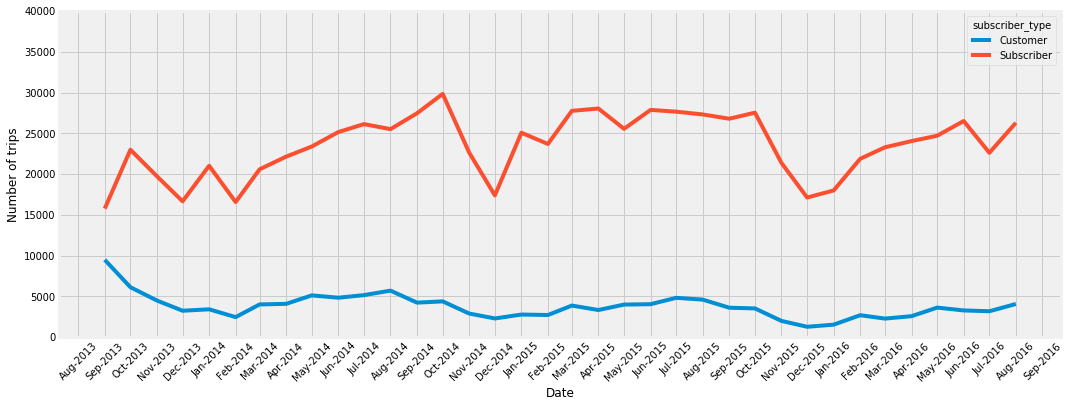

In [23]:
#exclude august since august only has 2 days' worth of data
data = (df[df.end_date_month > '2013-08-01']
        .groupby(['end_date_month', 'subscriber_type',])
        .trip_id
        .count()
        .to_frame()
        .reset_index())

#rename columns and format them for timeseries graph
data.columns = ['end_date_month', 'subscriber_type', 'trip_count']
data.end_date_month = mdates.date2num(data.end_date_month)
data.sort_values(by='end_date_month', inplace=True)

#graph the aggregated monthly trip count
fig = (data
       .pivot(index='end_date_month',
              columns='subscriber_type',
              values ='trip_count')
       .plot(figsize=(16,6)))

plt.xlabel('Date')
plt.ylabel('Number of trips')
plt.style.use('fivethirtyeight')
plt.ylim(0,40000)
plt.xticks(rotation=45)

months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%b-%Y')

fig.xaxis.set_major_locator(months)
fig.xaxis.set_major_formatter(monthsFmt)

## 3.2. How does the amount of trips vary by day?

The variation in trip number was analyzed by week day. On the whole weekdays (Monday-Friday) are populars time for trips, and in particular Tuesday is the most popular day for trips (about 1000+ trips on average). During weekdays, subscribers (annual and 30-day members) account for the majority of the trips on weekdays. The number of trips done by "Customer" (24 hour or 3-day member) peaks on weekends. The number of trips during the weekend however, is much lower compared to weekdays.

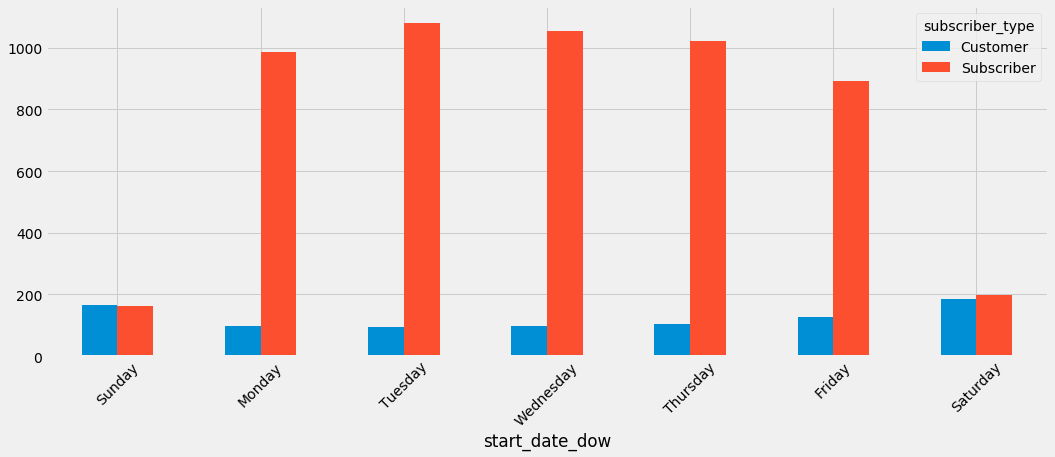

In [17]:
#trip count grouped by week day and subscriber type
data = df.groupby(['subscriber_type', 'start_date_dow']).trip_id.count().to_frame()
data.columns = ['trip_count']

#get weekday count for each week day and subscriber type so avg trip per weekday can be calculated
data['start_date_dow_count'] = df.groupby(['subscriber_type', 'start_date_dow']).start_date_day.nunique()

#reset index, and calculate the avg trip for each weekday
data.reset_index(inplace=True)
data['avg_trip_per_day'] = round(data.trip_count/data.start_date_dow_count, 2)

#graph pivoted dataframe to get side by side bar chart
fig = (data
      .pivot(index='start_date_dow',
             columns='subscriber_type',
             values='avg_trip_per_day')
      .plot(kind='bar', figsize=(16,6)))

#rotate x-axis label by 45 deg
plt.xticks(rotation=45)

plt.show()

## 3.3. How does the amount of trips vary by time of day?

The variation in trip number was analyzed by week day and time of day. On the whole weekdays (Monday-Friday), 7a-9a, and 4p-6p have the most trips by subscribers and in general. On weekends, the busiest time is between 11 AM and 4 PM. This finding indicates that the GoBikes are generally used for commuting during weekdays.

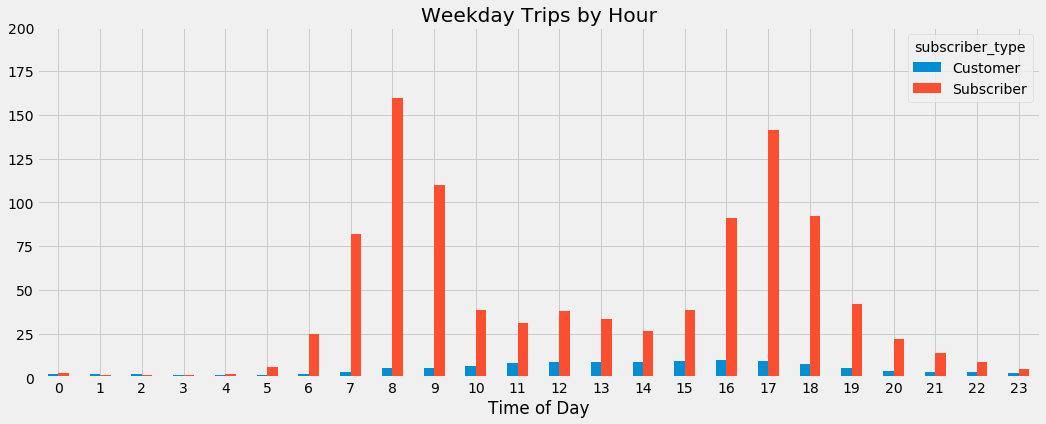

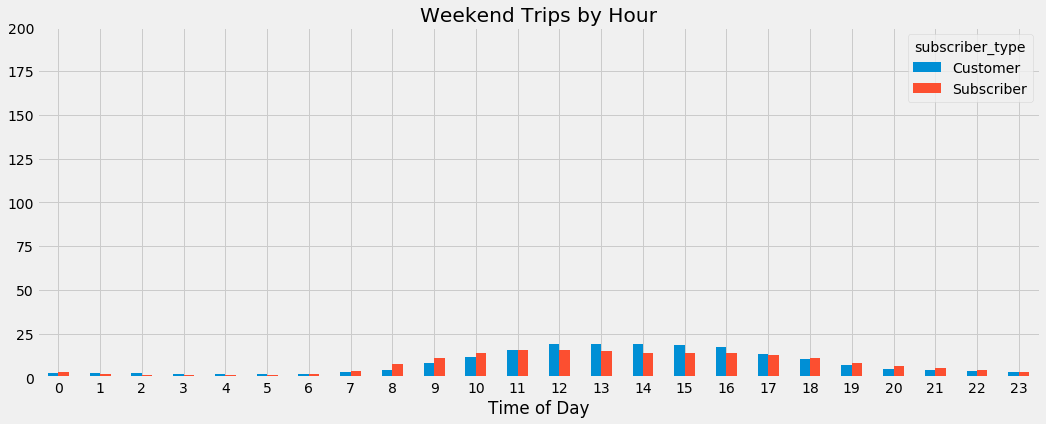

In [18]:
#set of days and title for the for loop
days = [['Monday','Tuesday','Wednesday','Thursday','Friday'], ['Saturday', 'Sunday']]
titles = ['Weekday Trips by Hour', 'Weekend Trips by Hour']

for d,t in list(zip(days,titles)):
    #trip count grouped by time of day and subscriber type
    data = (df[df.start_date_dow.isin(d)]
            .groupby(['subscriber_type', 'start_date_tod'])
            .trip_id.count()
            .to_frame())
    data.columns = ['trip_count']
    
    #get time of day count for hour and subscriber type so avg trip for that time of day can be calculated
    data['start_date_tod_count'] = (df[df.start_date_dow.isin(d)]
                                    .groupby(['subscriber_type', 'start_date_tod'])
                                    .start_date_day.nunique())
    #reset index, and calculate the avg trip for each weekday
    data.reset_index(inplace=True)
    data['avg_trip_count'] = round(data.trip_count/data.start_date_tod_count, 2)
    
    #graph pivoted dataframe to get side by side bar chart
    fig = (data
          .pivot(index='start_date_tod',
                 columns='subscriber_type',
                 values='avg_trip_count')
          .plot(kind='bar', figsize=(16,6)))
    
    #adjust labels, titles, etc.
    plt.xticks(rotation=0)
    plt.ylim(0,200)
    plt.title(t)
    plt.xlabel('Time of Day')
    plt.show()

## 3.4. How long of a ride do people take?
Based on the analysis of ride duration, it looks like subscribers who tend to be commuters take a fairly short ride since typically the bikes are are used as means commuting, meanwhile customers tend to use the bike as a form for leisurely activity, hence taking longer bike rides compared to the subscribers.

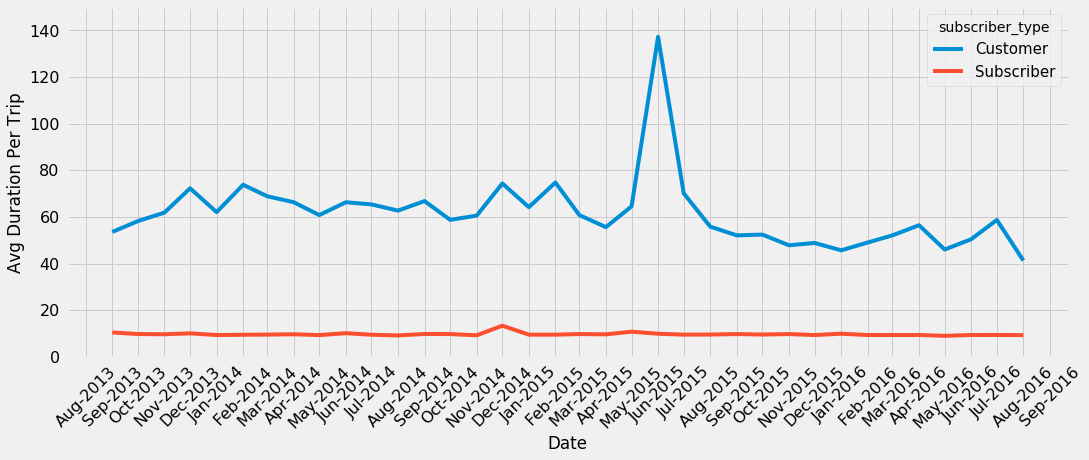

In [52]:
#exclude august since august only has 2 days' worth of data
data = (df[df.end_date_month > '2013-08-01']
        .groupby(['end_date_month', 'subscriber_type'])
        .trip_id
        .count()
        .to_frame())

#rename column
data.columns = ['trip_count']

#add trip duration data
data['total_trip_duration'] = (df[df.end_date_month > '2013-08-01']
                               .groupby(['end_date_month', 'subscriber_type',])
                               .duration_sec
                               .sum()/60)

#reset the index and format columns for time series graph
data.reset_index(inplace=True)
data['avg_duration_per_trip'] = data.total_trip_duration/data.trip_count
data['end_date_month'] = mdates.date2num(data.end_date_month)

#plot the graph
fig = (data
       .pivot(index='end_date_month', columns='subscriber_type' ,values ='avg_duration_per_trip')
       .plot(figsize=(16,6)))

        
plt.xlabel('Date')
plt.ylabel('Avg Duration Per Trip')
plt.style.use('fivethirtyeight')
plt.ylim(0,150)
plt.xticks(rotation=45)

months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%b-%Y')

fig.xaxis.set_major_locator(months)
fig.xaxis.set_major_formatter(monthsFmt)

plt.show()


## 3.5. What are the 5 most popular' commuter' trips?
The location combination and the total trip count was analyzed. One thing that was not expected is that the top 5 list of location combination for morning commute is not the same as the top 5 location combination for the afternoon commute. An additional investigation will be needed to see if this is due to availability issue.

In [19]:
#subset data to only contain monday-friday
data = df[~df.start_date_dow.isin(['Saturday', 'Sunday'])].copy()

#add start and end location combination column
data['start_end_loc_combo'] = data.start_station_name + ' - ' + data.end_station_name

In [20]:
#list out the top 5 location combination for morning commutes
morning_commute = (data[data.start_date_tod.isin([7,8,9])]
                   .groupby(['start_station_name', 'end_station_name'])
                   .trip_id
                   .count()
                   .sort_values(ascending=False)
                   .to_frame()
                   .reset_index())

morning_commute.columns = ['start_station_name', 'end_station_name', 'trip_count']

morning_commute.head()

,start_station_name,end_station_name,trip_count
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,4509
1,Steuart at Market,2nd at Townsend,3759
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,3512
3,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,3364
4,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),3126


In [21]:
#list out the top 5 location combination for afternoon commutes
afternoon_commute = (data[data.start_date_tod.isin([16,17,18])]
                   .groupby(['start_station_name', 'end_station_name'])
                   .trip_id
                   .count()
                   .sort_values(ascending=False)
                   .to_frame()
                   .reset_index())

afternoon_commute.columns = ['start_station_name', 'end_station_name', 'trip_count']

afternoon_commute.head()

,start_station_name,end_station_name,trip_count
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),4191
1,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),4022
2,Embarcadero at Sansome,Steuart at Market,3863
3,Steuart at Market,San Francisco Caltrain (Townsend at 4th),3393
4,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),3326


## 3.6. Is there a bike availability issue that is potentially preventing trips to be initiated?
Based on the descriptive statistics, it looks like some of the stations that are popular starting location for morning and afternoon commutes on occassion do not have any bikes available, thus preventing potential interested riders in being able to use a bike to get to their destination.

In [23]:
#create dictionary to map station_id to station_name for sql_df
station_name_dict = df.set_index('start_station_id').start_station_name.to_frame().drop_duplicates().reset_index()
station_name_dict = dict(zip(station_name_dict.start_station_id, station_name_dict.start_station_name))

#map the dictionary
sql_df['station_name'] = sql_df.station_id.map(station_name_dict)

In [24]:
#morning commute station distribution of available bikes
data = sql_df[sql_df.station_name.isin(morning_commute.start_station_name.head().unique())]
data = data[data.date_tod.isin([7,8,9])]
(data
 .groupby('station_name')
 .avg_bikes_available
 .describe())

,count,mean,std,min,25%,50%,75%,max
station_name,,,,,,,,
Harry Bridges Plaza (Ferry Building),3288.0,11.486597,5.390034,0.00,7.5225,12.00,15.82,23.0
San Francisco Caltrain (Townsend at 4th),3289.0,8.414071,4.900398,0.02,3.7000,8.58,12.55,19.0
San Francisco Caltrain 2 (330 Townsend),3289.0,12.339532,5.574153,0.22,8.0000,12.97,17.00,23.0
Steuart at Market,3289.0,11.952378,5.100161,0.00,8.3700,12.00,15.77,23.0


In [25]:
#afternoon commute station distribution of available bikes
data = sql_df[sql_df.station_name.isin(afternoon_commute.start_station_name.head().unique())]
data = data[data.date_tod.isin([16,17,18])]
(data
 .groupby('station_name')
 .avg_bikes_available
 .describe())

,count,mean,std,min,25%,50%,75%,max
station_name,,,,,,,,
2nd at Townsend,3291.0,11.811671,5.512050,0.00,7.875,11.57,15.435,27.00
Embarcadero at Folsom,3285.0,6.784414,3.559964,0.00,4.000,6.55,9.180,18.75
Embarcadero at Sansome,3291.0,6.985111,3.641619,0.00,3.980,7.00,9.870,15.00
Steuart at Market,3291.0,10.439183,5.236519,0.07,6.230,10.10,14.375,22.63
Temporary Transbay Terminal (Howard at Beale),3291.0,10.119134,4.661414,0.00,6.630,10.00,13.360,22.82


## 3.7. How does weather affect ridership?
Based on the temperature, it seems that people tend to ride bikes when the temperature 50 and 70 degrees. In addition based on categorical weather description, people tend to ride bikes during a somewhat rainy condition, and this may be due to people wanting to reach their destination faster while it is raining out.

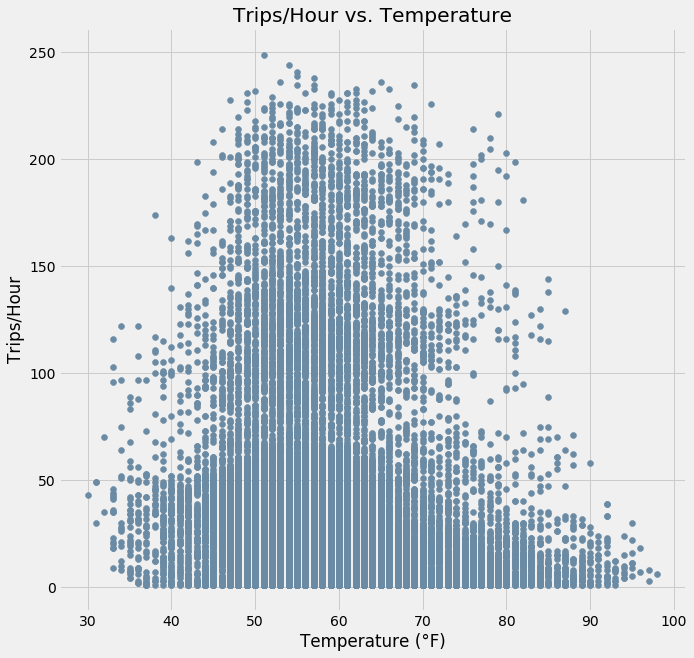

In [26]:
data = (df
        .groupby(['start_date_hour', 'start_date_hour_temp'])
        .trip_id.count()
        .to_frame()
        .reset_index())

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))
plt.xlabel('Temperature (°F)')
plt.ylabel('Trips/Hour')
plt.title('Trips/Hour vs. Temperature')
plt.scatter(x=data.start_date_hour_temp, y=data.trip_id, c="#6b8ba4")

plt.show()

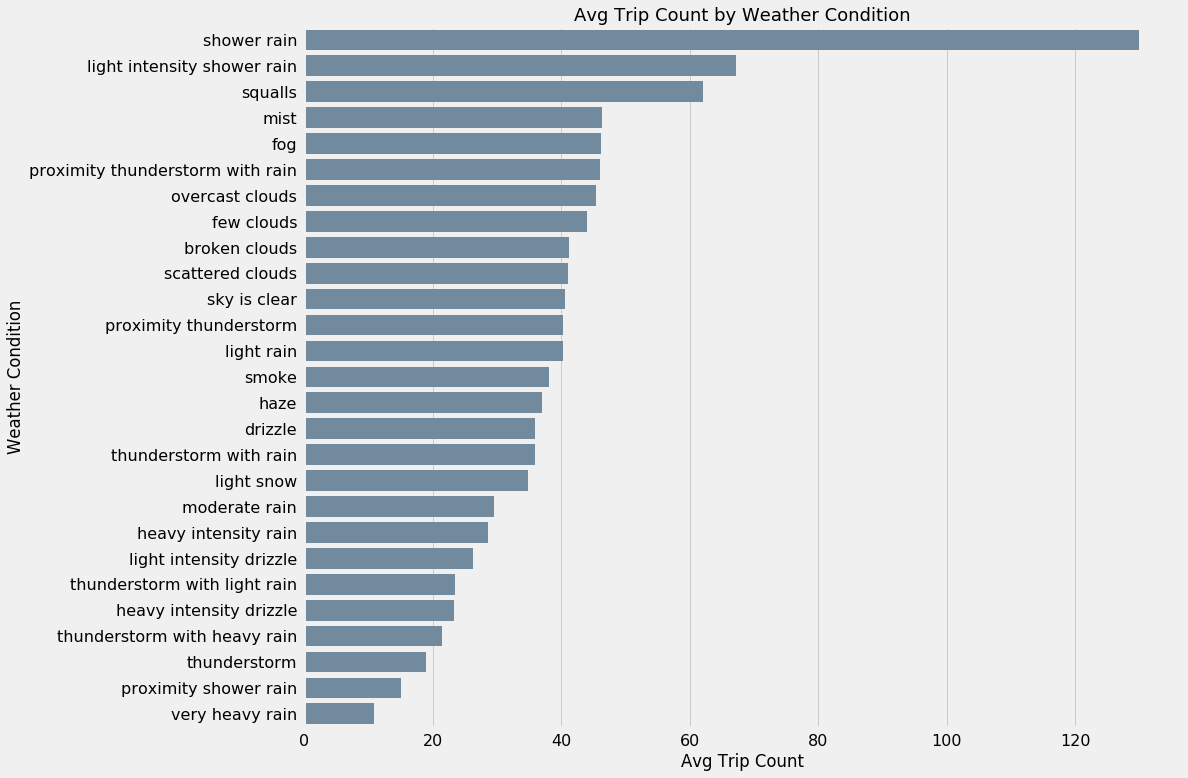

In [32]:
data = df.groupby(['start_date_hour', 'start_date_hour_weather']).trip_id.count().to_frame().reset_index()

data.columns=['start_date_hour', 'start_date_hour_weather', 'trip_count']

data = data.groupby('start_date_hour_weather').trip_count.mean().sort_values(ascending=False).to_frame().reset_index()

plt.style.use('fivethirtyeight')
plt.figure(figsize=(14,12))

sns.set_context("notebook", font_scale=1.5, rc={"xtick.labelsize":16, "ytick.labelsize":16})
ax = sns.barplot(x="trip_count",
            y="start_date_hour_weather",
            data=data,
            color="#6b8ba4")
ax.set(xlabel='Avg Trip Count', ylabel='Weather Condition', title = 'Avg Trip Count by Weather Condition')

plt.show()

## 3.8. Ridge Regression
Since there are a few factors that impact ridership, a ridge regression can be ran to determine which of these factors are most important in determining the number of trips. Based on the model, commute hours plays the biggest role in increasing number of trips, followed by wet weather conditions. On the otherhand, high temperatures tend to decrease ridership as well as extremely wet conditions as people tend to opt to stay in under those two conditions.

In [53]:
def commute_ind(df):
    """determines if the time of day (0-23) is considered commuting hours"""
    if 7 <= df <= 9:
        return 1
    elif 16 <= df <= 18:
        return 1
    else:
        return 0

In [54]:
#subset the data
data = (df
        .groupby(['start_date_hour',
                  'start_date_hour_weather',
                  'start_date_hour_temp',
                  'start_date_dow',
                  'start_date_tod',
                  'start_date_moy'])
        .trip_id
        .count()
        .to_frame())

#rename the column
data.columns=['trip_count']
data.reset_index(inplace=True)

#join in bike status data
data.set_index(['start_date_hour'], inplace=True)
data['avg_bikes_available'] = sql_df.set_index(['date_hour']).avg_bikes_available.mean()

#add a commute_hours indicator column 
data['commute_hours'] = data.start_date_tod.apply(commute_ind)
data.reset_index(inplace=True)

#drop variables not being used for the model
data.drop(['start_date_hour','start_date_tod'], axis=1, inplace=True)
data.dropna(inplace=True)

#dummify categorical data
dummy_features = ['start_date_dow', 'start_date_moy', 'start_date_hour_weather']

for x in dummy_features:
    data = data.join(pd.get_dummies(data[x]))
    data.drop(x, axis=1, inplace=True)

#drop nas just in case the dummifying process has rows with nas
data.dropna(inplace=True)

In [55]:
#features
feature_names = list(data.columns)
feature_names.remove('trip_count')

#train test split
X = data[feature_names] 
y = data['trip_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

#scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
#apply the scaling to the test set that we computed for the training set
X_test = scaler.transform(X_test)

#fit then print model performance
regression = Ridge().fit(X_train, y_train)
print('R-squared score (training): {:.3f}'.format(regression.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'.format(regression.score(X_test, y_test)))

R-squared score (training): 0.558
R-squared score (test): 0.560


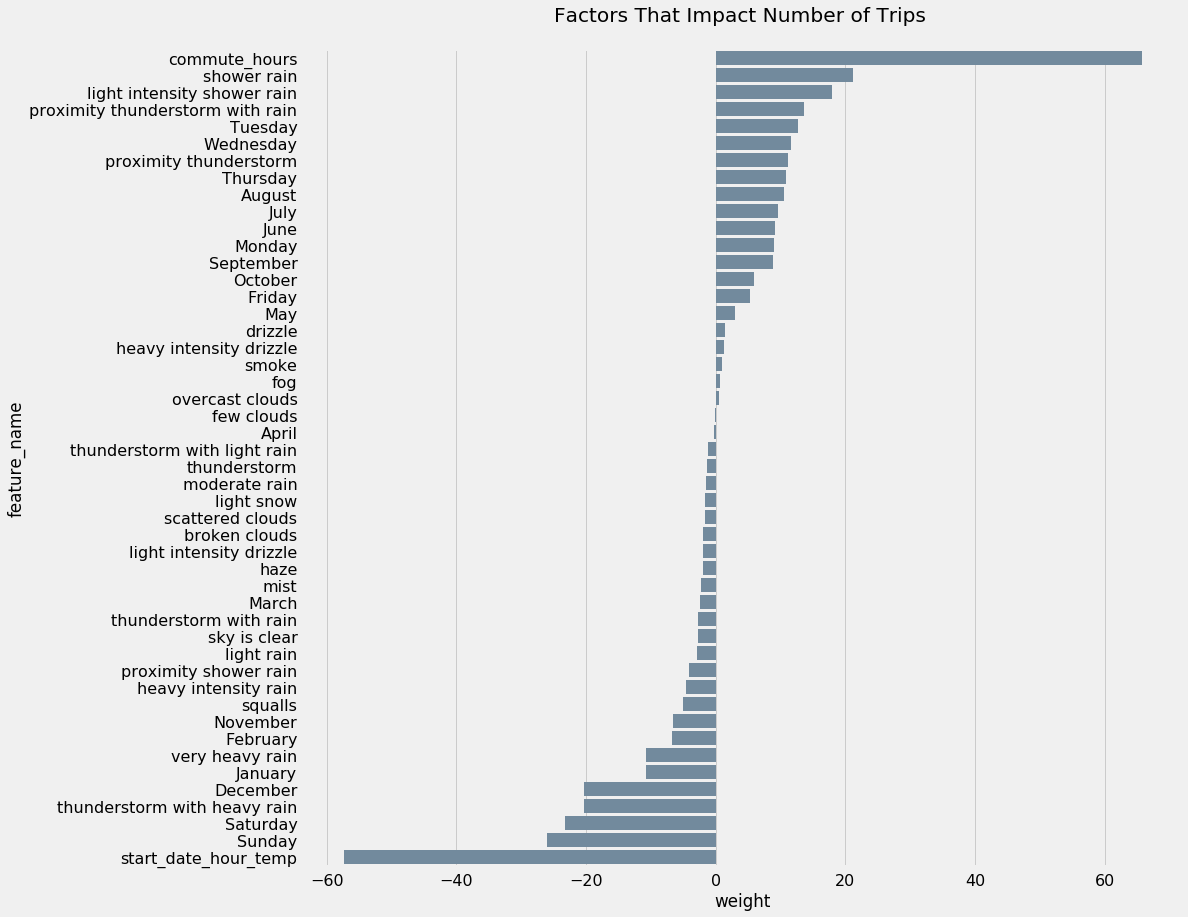

In [56]:
feature_dfb = pd.DataFrame(list(zip(feature_names,regression.coef_)),columns=['feature_name','weight']).sort_values('weight')


plt.style.use('fivethirtyeight')
plt.figure(figsize=(14,14))
plt.xlabel('Weight')
plt.ylabel('Factors')
plt.title('Factors That Impact Number of Trips \n')
sns.barplot(x="weight",
            y="feature_name",
            data=feature_dfb[feature_dfb.weight!=0].sort_values(by="weight", ascending=False),
            color="#6b8ba4")

plt.show()

# 4. Summary and Recommendations
* Majority of the trips are done by subscribers, and subscribers mainly use it during commute hours (i.e. 7a-9a, and 4p-6p on weekdays)
* Ridership is low for both customers and subscribers during weekends, showing that people in San Francisco primarily uses the bikes for commuting to and from work. Ford goBikes can perhaps do promotions to increase ridership over the weekend.
* Customers who do not pay any subscription fees tend to go on long leisurely bike rides, and since there are not a lot of customer riders, Ford goBike can perhaps do promotion (e.g. providing discounts for 1 hour ride) to gain more non-subscriber riders.
* There are times where there are no bikes available during commute hours as shown in 4.6, so Ford goBike, may want to consider adding more docks and bikes to some of the more popular station so that they do not lose riders. In addition, Ford goBike may want to consider doing one way specials during commute hours to help replenish some of the depleted bike stations. 
* The Model and the time series graph shows that there are months where the number of riders tend to dip, so during these months the company may want to consider doing some specials to bolster the number of rides.